In [8]:
# !pip install lifetimes

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from lifetimes.datasets import load_cdnow_summary
data = load_cdnow_summary(index_col=[0])

print(data.head())

    frequency  recency      T
ID                           
1           2    30.43  38.86
2           1     1.71  38.86
3           0     0.00  38.86
4           0     0.00  38.86
5           0     0.00  38.86


In [5]:
from lifetimes import BetaGeoFitter

In [6]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


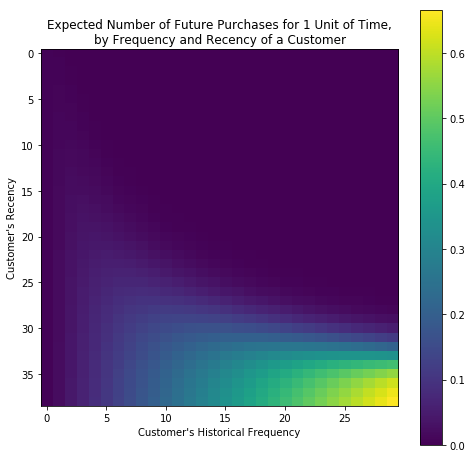

In [13]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)
plt.gcf().set_size_inches(8,8)

In [14]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)


,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,0.424877
841,19,34.00,34.14,0.474738
1981,17,28.43,28.86,0.486526
157,29,37.71,38.00,0.662396
1516,26,30.86,31.00,0.710623


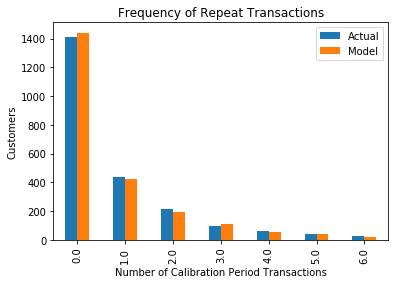

In [15]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)


In [16]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = load_transaction_data()
print(transaction_data.head())

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2


In [18]:

summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')

summary.head()

,frequency,recency,T
id,,,
0,0.0,0.0,298.0
1,0.0,0.0,224.0
2,6.0,142.0,292.0
3,0.0,0.0,147.0
4,2.0,9.0,183.0


In [19]:
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 1.85, alpha: 1.86, b: 3.18, r: 0.16>

In [53]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                        calibration_period_end='2014-09-01',
                                        observation_period_end='2014-12-31' )   
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
id,,,,,
0,0.0,0.0,177.0,0.0,121
1,0.0,0.0,103.0,0.0,121
2,6.0,142.0,171.0,0.0,121
3,0.0,0.0,26.0,0.0,121
4,2.0,9.0,62.0,0.0,121


In [34]:
transaction_data.head()

,date,id
0,2014-03-08 00:00:00,0
1,2014-05-21 00:00:00,1
2,2014-03-14 00:00:00,2
3,2014-04-09 00:00:00,2
4,2014-05-21 00:00:00,2


In [55]:
import pandas as pd
datetime_col = 'date'
customer_id_col = 'id'
datetime_format = None

calibration_period_end = '2014-09-01'
observation_period_end = '2014-12-31'

freq = 'D'
transactions = transaction_data
transaction_cols = [customer_id_col, datetime_col]
transactions = transactions[transaction_cols].copy()


transactions[datetime_col] = pd.to_datetime(transactions[datetime_col], format=datetime_format)
observation_period_end = pd.to_datetime(observation_period_end, format=datetime_format)
calibration_period_end = pd.to_datetime(calibration_period_end, format=datetime_format)

calibration_transactions = transactions.loc[transactions[datetime_col] <= calibration_period_end]
holdout_transactions = transactions.loc[(observation_period_end >= transactions[datetime_col]) & (transactions[datetime_col] > calibration_period_end)]

In [51]:
calibration_transactions.describe(include='all')

,id,date
count,13202.000000,13202
unique,NaN,244
top,NaN,2014-08-12 00:00:00
freq,NaN,86
first,NaN,2014-01-01 00:00:00
last,NaN,2014-09-01 00:00:00
mean,2513.836161,NaN
std,1441.940888,NaN
min,0.000000,NaN
25%,1281.000000,NaN


In [50]:
holdout_transactions.describe(include='all')

,id,date
count,2071.000000,2071
unique,NaN,121
top,NaN,2014-09-03 00:00:00
freq,NaN,56
first,NaN,2014-09-02 00:00:00
last,NaN,2014-12-31 00:00:00
mean,2545.085949,NaN
std,1505.269160,NaN
min,20.000000,NaN
25%,1268.000000,NaN


In [67]:
calibration_summary_data = summary_data_from_transaction_data(calibration_transactions,
                                                              customer_id_col,
                                                              datetime_col,
                                                              datetime_format=datetime_format,
                                                              observation_period_end=calibration_period_end,
                                                              freq=freq)
calibration_summary_data.columns = [c + '_cal' for c in calibration_summary_data.columns]
holdout_summary_data = holdout_transactions.groupby([customer_id_col, datetime_col], sort=False).agg(lambda r: 1)\
                                               .groupby(level=customer_id_col).agg(['count'])
holdout_summary_data.columns = ['frequency_holdout']
delta_time = observation_period_end.to_period(freq) - calibration_period_end.to_period(freq)
calibration_summary_data['duration_holdout'] = delta_time

In [68]:
calibration_summary_data.head()

,frequency_cal,recency_cal,T_cal,duration_holdout
id,,,,
0,0.0,0.0,177.0,121
1,0.0,0.0,103.0,121
2,6.0,142.0,171.0,121
3,0.0,0.0,26.0,121
4,2.0,9.0,62.0,121


In [58]:
holdout_summary_data.head()

,frequency_holdout
id,
20,2
22,3
35,9
84,3
88,4


In [59]:
bgf.fit(calibration_summary_data['frequency_cal'], calibration_summary_data['recency_cal'], calibration_summary_data['T_cal'])


<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 1.96, alpha: 2.26, b: 3.48, r: 0.19>

In [69]:
summary = calibration_summary_data
model = bgf
duration_holdout = summary.iloc[0]['duration_holdout']
summary['model_predictions'] = summary.apply(lambda r: model.conditional_expected_number_of_purchases_up_to_time(duration_holdout, r['frequency_cal'], r['recency_cal'], r['T_cal']), axis=1)

In [70]:
summary.head()

,frequency_cal,recency_cal,T_cal,duration_holdout,model_predictions
id,,,,,
0,0.0,0.0,177.0,121,0.112786
1,0.0,0.0,103.0,121,0.178463
2,6.0,142.0,171.0,121,1.767622
3,0.0,0.0,26.0,121,0.475414
4,2.0,9.0,62.0,121,0.114192


In [71]:
holdout_summary_data.head()

,frequency_holdout
id,
20,2
22,3
35,9
84,3
88,4


In [72]:
full_summ = calibration_summary_data.join(holdout_summary_data, how='left')
full_summ.fillna(0, inplace=True)

In [73]:
full_summ.head()

,frequency_cal,recency_cal,T_cal,duration_holdout,model_predictions,frequency_holdout
id,,,,,,
0,0.0,0.0,177.0,121,0.112786,0.0
1,0.0,0.0,103.0,121,0.178463,0.0
2,6.0,142.0,171.0,121,1.767622,0.0
3,0.0,0.0,26.0,121,0.475414,0.0
4,2.0,9.0,62.0,121,0.114192,0.0


In [75]:
plotting_data = full_summ.groupby(by=['frequency_cal'])['frequency_holdout', 'model_predictions'].mean()

In [76]:
plotting_data.head()

,frequency_holdout,model_predictions
frequency_cal,,
0.0,0.161079,0.269892
1.0,0.233171,0.293861
2.0,0.347826,0.401599
3.0,0.543796,0.422267
4.0,0.710059,0.705816


In [99]:
plotting_data['abs_pct_err'] = np.abs(plotting_data['frequency_holdout'] - plotting_data['model_predictions']) / plotting_data['frequency_holdout'].replace(to_replace=0.0, value=1.0)


1.9306608203725948

In [106]:
full_summ_size = full_summ.groupby(by=['frequency_cal']).size().reset_index()
full_summ_size.columns = ['frequency_cal', 'txn_ct']
full_summ_size.set_index('frequency_cal')

,txn_ct
frequency_cal,
0.0,2595
1.0,1025
2.0,529
3.0,274
4.0,169
5.0,115
6.0,66
7.0,46
8.0,37


In [108]:
plotting_data_wt = plotting_data.join(full_summ_size, how='left')
plotting_data_wt.head()

,frequency_holdout,model_predictions,abs_pct_err,frequency_cal,txn_ct
frequency_cal,,,,,
0.0,0.161079,0.269892,0.675525,0.0,2595.0
1.0,0.233171,0.293861,0.260281,1.0,1025.0
2.0,0.347826,0.401599,0.154598,2.0,529.0
3.0,0.543796,0.422267,0.223483,3.0,274.0
4.0,0.710059,0.705816,0.005976,4.0,169.0


In [112]:
plotting_data_wt['txn_ct_share'] = plotting_data_wt['txn_ct'] / np.sum(plotting_data_wt['txn_ct'])
plotting_data_wt['abs_pct_err_wt'] = plotting_data_wt['abs_pct_err'] * plotting_data_wt['txn_ct_share'].fillna(0.0)

In [113]:
plotting_data_wt

,frequency_holdout,model_predictions,abs_pct_err,frequency_cal,txn_ct,abs_pct_err_wt,txn_ct_share
frequency_cal,,,,,,,
0.0,0.161079,0.269892,0.675525,0.0,2595.0,3.510890e-01,0.519728
1.0,0.233171,0.293861,0.260281,1.0,1025.0,5.343247e-02,0.205287
2.0,0.347826,0.401599,0.154598,2.0,529.0,1.637935e-02,0.105948
3.0,0.543796,0.422267,0.223483,3.0,274.0,1.226404e-02,0.054877
4.0,0.710059,0.705816,0.005976,4.0,169.0,2.022699e-04,0.033847
5.0,0.704348,0.809352,0.149080,5.0,115.0,3.433654e-03,0.023032
6.0,1.606061,1.018576,0.365792,6.0,66.0,4.835227e-03,0.013219
7.0,1.695652,1.545798,0.088376,7.0,46.0,8.141953e-04,0.009213
8.0,1.648649,1.207087,0.267833,8.0,37.0,1.984741e-03,0.007410


In [114]:
np.mean(plotting_data_wt['abs_pct_err_wt'])

0.013829456570961386

In [79]:
df = plotting_data.reset_index()
plotting_temp = pd.melt(df, id_vars=['frequency_cal'], value_vars=['frequency_holdout', 'model_predictions'])
plotting_temp.head()

,frequency_cal,variable,value
0,0.0,frequency_holdout,0.161079
1,1.0,frequency_holdout,0.233171
2,2.0,frequency_holdout,0.347826
3,3.0,frequency_holdout,0.543796
4,4.0,frequency_holdout,0.710059


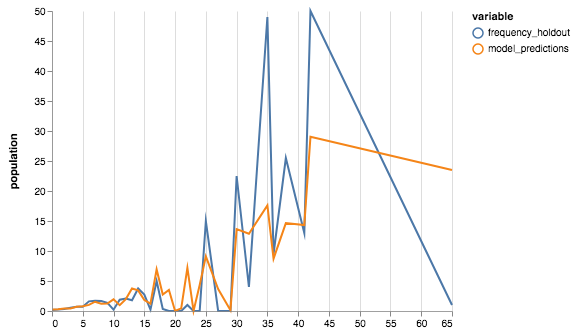

In [97]:
import altair as alt
alt.Chart(plotting_temp).mark_line(stroke='transparent').encode(
    x=alt.X('frequency_cal:Q', scale=alt.Scale(rangeStep=12), axis=alt.Axis(title='')),
    y=alt.Y('value:Q', axis=alt.Axis(title='population', grid=False)),
    color='variable:N'
    
).configure_view(
    stroke='transparent'
).configure_axis(
    domainWidth=0.8
)

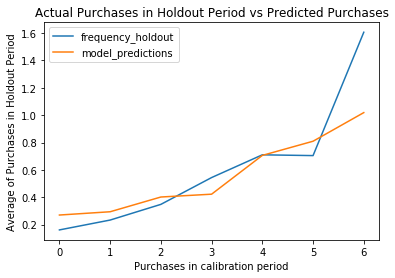

In [23]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)


In [87]:
full_summ.head()

,frequency_cal,recency_cal,T_cal,duration_holdout,model_predictions,frequency_holdout
id,,,,,,
0,0.0,0.0,177.0,121,0.112786,0.0
1,0.0,0.0,103.0,121,0.178463,0.0
2,6.0,142.0,171.0,121,1.767622,0.0
3,0.0,0.0,26.0,121,0.475414,0.0
4,2.0,9.0,62.0,121,0.114192,0.0


In [94]:
import numpy as np
full_summ['abs_pct_err'] = np.abs(full_summ['frequency_holdout']- full_summ['model_predictions']) /full_summ['frequency_holdout'].replace(to_replace=0.0, value=1.0)

In [95]:
np.mean(full_summ['abs_pct_err'])

0.3259894224130879

In [98]:
np.mean(full_summ[full_summ['frequency_holdout'] > 0]['abs_pct_err'])

0.789020096424076

In [24]:
t = 10 #predict purchases in 10 periods
individual = summary.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])
# 0.0576511


0.057651226890431936

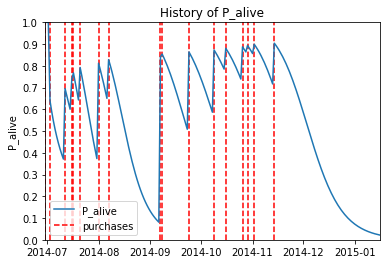

In [26]:
from lifetimes.plotting import plot_history_alive

id = 35
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')


In [27]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

returning_customers_summary.head()

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
6,7,29.43,38.86,73.74
7,1,5.00,38.86,11.77
9,2,35.71,38.86,25.55


In [28]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


In [29]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>


In [30]:
print(ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).head(10))

customer_id
1     24.658618
2     18.911483
3     35.171009
4     35.171009
5     35.171009
6     71.462851
7     18.911483
8     35.171009
9     27.282409
10    35.171009
dtype: float64


In [31]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))


Expected conditional average profit: 35.252962713121704, Average profit: 35.07855179704026


In [32]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

customer_id
1      140.095606
2       18.943402
3       38.180565
4       38.180565
5       38.180565
6     1003.861403
7       28.109578
8       38.180565
9      167.417525
10      38.180565
Name: clv, dtype: float64
